# Introduction to WaveNet
## Jonathan Balaban

WaveNet is a powerful new predictive technique that uses multiple Deep Learning (DL) strategies from Computer Vision (CV) and Audio Signal Processing models and applies them to longitudinal (time-series) data. It was created by researchers at London-based artificial intelligence firm [DeepMind](https://deepmind.com), and currently powers [Google Assistant voices](https://assistant.google.com).

We'll explore WaveNet and how it works, but first dive into data prep, current high-performance models (as a baseline, Facebook Prophet), and then compare results!

>run this full line in bash, as one line:

`conda create -n wavenet python=3.7 pandas numpy seaborn matplotlib jupyter keras`

>then install Facebook Prophet:

`source activate wavenet; conda install -c conda-forge fbprophet`

# Data Setup

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [64]:
# load Apple stock
aapl_raw = pd.read_csv('./AAPL-2000-2019.csv')

In [65]:
aapl_raw.info()

# we need to set date as datetime object and index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4779 entries, 0 to 4778
Data columns (total 7 columns):
Date         4779 non-null object
Open         4779 non-null float64
High         4779 non-null float64
Low          4779 non-null float64
Close        4779 non-null float64
Adj Close    4779 non-null float64
Volume       4779 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 261.4+ KB


In [66]:
# set index
aapl_raw.index = pd.to_datetime(aapl_raw.Date)

In [67]:
# check
aapl_raw.head()

# looks good!

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2000-04-18,2000-04-18,4.410714,4.531250,4.263393,4.531250,3.021451,97731200
2000-04-19,2000-04-19,4.506696,4.651786,4.276786,4.325893,2.884518,130037600
2000-04-20,2000-04-20,4.417411,4.455357,4.180804,4.245536,2.830937,180530000
2000-04-24,2000-04-24,4.107143,4.303571,4.098214,4.303571,2.869634,110905200
2000-04-25,2000-04-25,4.361607,4.598214,4.359375,4.582589,3.055684,97910400


In [68]:
# rename Adj Close to AC, get rid of pesky spacing
aapl_raw['AC'] = aapl_raw['Adj Close']

>Based on [this article](https://finance.zacks.com/adjusted-closing-price-vs-closing-price-9991.html) and others, let's use Adj Close as our series.

>[MACD is often used by investors as a buy/sell indicator](https://www.investopedia.com/terms/m/macd.asp), so it should help track patterns and trend changes!

In [69]:
# good, drop Date and everything but AC and Volume
aapl = aapl_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close'])
aapl.head()

,Volume,AC
Date,,
2000-04-18,97731200,3.021451
2000-04-19,130037600,2.884518
2000-04-20,180530000,2.830937
2000-04-24,110905200,2.869634
2000-04-25,97910400,3.055684


In [70]:
aapl.describe().round(2)

,Volume,AC
count,4.779000e+03,4779.00
mean,1.182295e+08,47.69
std,9.954219e+07,56.83
min,9.835000e+06,0.62
25%,5.056905e+07,3.35
50%,9.088870e+07,18.33
75%,1.547458e+08,87.48
max,1.855410e+09,230.28


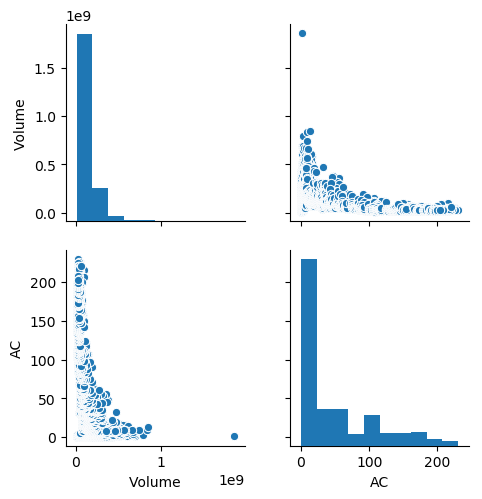

In [71]:
sns.pairplot(aapl);

We can note a few things from the EDA above:
- No NULLs
- Inverse exponential relationship between AC and Volume?
- Right skew in price

There's an important consideration also: **stock splits!**

Apple's stock has split four times since the company went public. The stock split on a 7-for-1 basis on June 9, 2014 and split on a 2-for-1 basis on February 28, 2005, June 21, 2000, and June 16, 1987.

Let's filter to the 2014 and 2005 weeks and see what happened:

# Statistics

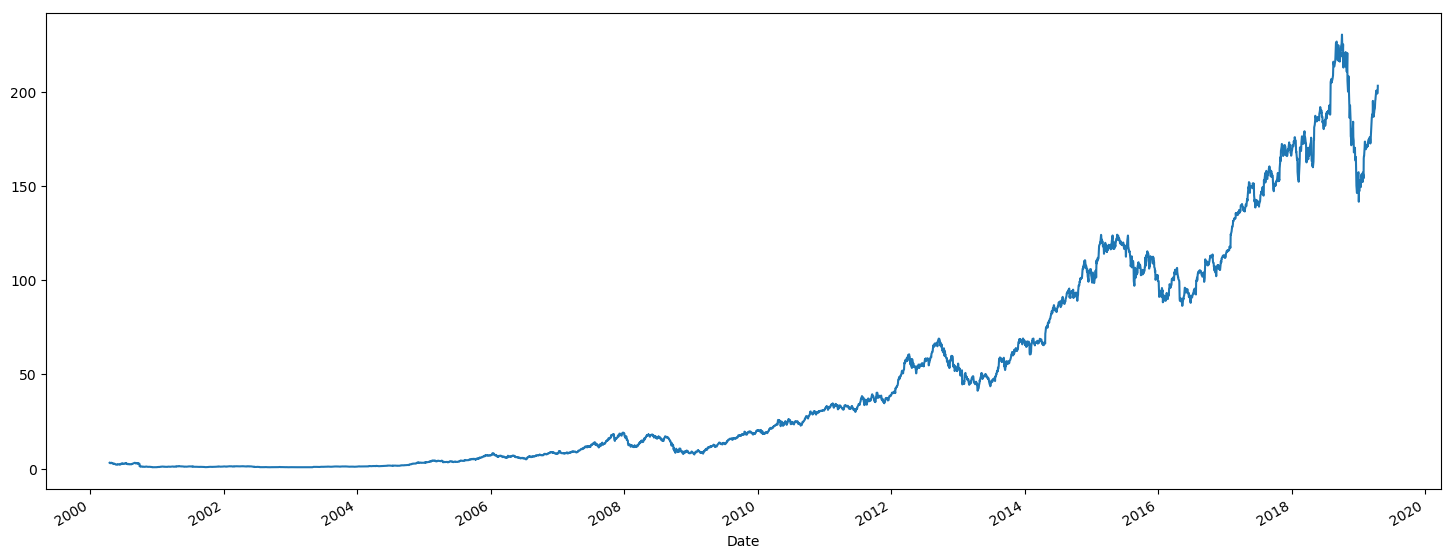

In [72]:
# plot price over time
aapl.AC.plot();

In [73]:
# Optional: run ADF to determine unit root
import statsmodels.tsa.stattools as ts
cadf = ts.adfuller(aapl_raw.AC)

print('Augmented Dickey Fuller:')
print('Test Statistic =',cadf[0])
print('p-value =',cadf[1])
print('Critical Values =',cadf[4])

Augmented Dickey Fuller:
Test Statistic = 1.0742834629100277
p-value = 0.9949910545329405
Critical Values = {'1%': -3.431728601011308, '5%': -2.862149185397661, '10%': -2.567094271358372}


# FB Prophet

# WaveNet

### Dilated Causal Convolution Layers
The model architecture we will build is a variant of the [WaveNet model](https://deepmind.com/blog/wavenet-generative-model-raw-audio/), but optimized for sequence data.

The **dilated causal convolution layer** is the default building block; Joe Eddy has a fantastic breakdown of [how it works here](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb) and [in his blog here](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/). In a nutshell, these layers (borrowed and modified from CNNs) are designed to learn detailed patterns from recent stock price movements, but also big-picture trends and cycles from months and years ago.

![dilated convolutions](./images/WaveNet_dilatedconv.png)

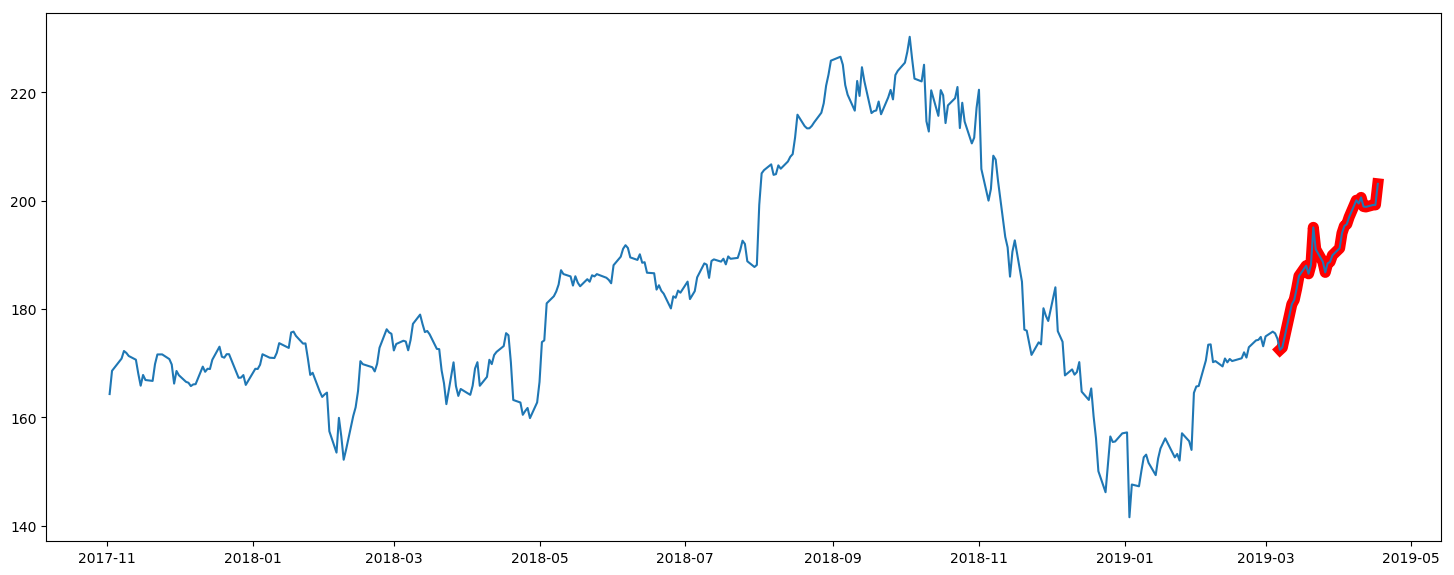

In [74]:
# looking back a month and year
plt.plot(aapl.AC.iloc[-30:], 'r', linewidth=8, markersize=12);
plt.plot(aapl.AC.iloc[-365:]);

# what intel can we gather from each timeframe?

### More building blocks:

We need to add a few other techniques:

![blocks](./images/WaveNet_residblock.png)

### **Gated Activations**

In the boxed portion of the architecture diagram above, note the dilated convolution splits into two branches that recombine via element-wise multiplication. This is a **gated activation unit**:
- **tanh:** activation branch is a learned (model optimized) filter
- **sigmoid:** activation branch is a learned gate that controls flow from the *tanh* filter (just like LSTM gates)

### Skip Connections

In fully-connected NNs, a neuron takes inputs from all neurons in the previous layer: early layers establish later ones via a hierarchy of intermediate computations. This allows NNs to build complex interactions of raw inputs/signals.

But... what if raw inputs are directly useful for prediction, and we want them to directly influence the output? **Skip connections** allow outputs of any layer to bypass multiple future layers and skip influence dilution! Keras allows us to store the tensor output of each convolutional block - in addition to passing it through further layers - with `skips.append()`. Note how for each block in the stack above, the output from the gated activations joins the set of skip connections. How much or how far you do this is a hyper-parameter that depends on your data and model structure!

### Residual Connections

![CNN_skips](./images/CNN_skips.png)

**Residual connections** are similar to skip connections: think of them as consistenly-available short layer skips! We'll use a one-layer skip for our model, but it's also a hyper-parameter. Why they help is mysterious, but it's most likely due to helping with the [Vanishing or Exploding Gradient](https://medium.com/learn-love-ai/the-curious-case-of-the-vanishing-exploding-gradient-bf58ec6822eb) obstacle in backpropagation. This becomes more important with larger models, but I'll show you the implementation in a smaller setting for educational purposes.

> Note: the diagram's *1x1 convolutions* are basically time-distributed fully connected layers; this allows us to use CNN language for our architecting!

![XKCD](./images/XKCD.png)

## Data Setup

First, Keras needs us to convert our series into `numpy` arrays. As we prep our data, we should have a partition strategy to validate and test our model's results. [Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) created a visualization of the **walk-forward validation** strategy that serves as a best practice:

![walk-forward validation](./images/ArturSuilin_validation.png)

Let's use this approach as we parse, learn, and validate our data!

In [75]:
# transpose to fit structure below
aapl = aapl[['Volume', 'AC']]
aapl = aapl.T
aapl.head()

Date,2000-04-18 00:00:00,2000-04-19 00:00:00,2000-04-20 00:00:00,2000-04-24 00:00:00,2000-04-25 00:00:00,2000-04-26 00:00:00,2000-04-27 00:00:00,2000-04-28 00:00:00,2000-05-01 00:00:00,2000-05-02 00:00:00,...,2019-04-04 00:00:00,2019-04-05 00:00:00,2019-04-08 00:00:00,2019-04-09 00:00:00,2019-04-10 00:00:00,2019-04-11 00:00:00,2019-04-12 00:00:00,2019-04-15 00:00:00,2019-04-16 00:00:00,2019-04-17 00:00:00
Volume,9.773120e+07,1.300376e+08,1.805300e+08,1.109052e+08,9.791040e+07,9.172800e+07,8.165080e+07,6.239520e+07,5.654880e+07,5.910800e+07,...,1.911430e+07,18526600.0,2.588170e+07,35768200.0,2.169530e+07,2.090080e+07,2.776070e+07,1.753660e+07,25696400.00,2.887490e+07
AC,3.021451e+00,2.884518e+00,2.830937e+00,2.869634e+00,3.055684e+00,2.888983e+00,3.018473e+00,2.954473e+00,2.960427e+00,2.807121e+00,...,1.956900e+02,197.0,2.001000e+02,199.5,2.006200e+02,1.989500e+02,1.988700e+02,1.992300e+02,199.25,2.031300e+02


In [76]:
from datetime import timedelta

data_start_date = aapl.columns[1]
data_end_date = aapl.columns[-1]

pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [77]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [78]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2000-04-19 00:00:00 - 2019-03-20 00:00:00
Train prediction: 2019-03-21 00:00:00 - 2019-04-03 00:00:00 

Val encoding: 2000-05-03 00:00:00 - 2019-04-03 00:00:00
Val prediction: 2019-04-04 00:00:00 - 2019-04-17 00:00:00

Encoding interval: 6910
Prediction interval: 14


In [79]:
aapl[aapl.columns[1:]].values

array([[1.30037600e+08, 1.80530000e+08, 1.10905200e+08, ...,
        1.75366000e+07, 2.56964000e+07, 2.88749000e+07],
       [2.88451800e+00, 2.83093700e+00, 2.86963400e+00, ...,
        1.99229996e+02, 1.99250000e+02, 2.03130005e+02]])

In [80]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in aapl.columns[1:]]),
                          data=[i for i in range(len(aapl.columns[1:]))])

series_array = aapl[aapl.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

# WaveNet Modeling

## Architecture Overview

Let's build our model like so:

* 16 dilated causal convolutional blocks
    * Pre and postprocessing (time distributed) fully connected layers (i.e. convolutions with filter width 1):
        * 16 output units
    * 32 filters of width 2 per block
    * Exponentially increasing dilation rate with a reset (1, 2, 4, 8,... 2^6), two sets
    * Gated activations
    * Residual and skip connections
* 2 fully connected layers to combine skip outputs to final output

In [81]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

In [82]:
# convolutional operation parameters
n_filters = 16 
filter_width = 2
dilation_rates = [2**i for i in range(5)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':10})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [83]:
# print our model architecture
#model.summary()

In [84]:
first_n_samples = 2

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]

encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

In [85]:
model.compile(Adam(), loss='mean_absolute_error')

history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=2**5,
                    epochs=50,
                    validation_split=0.1)

Train on 1 samples, validate on 1 samples
Epoch 1/50
1/1 [==============================] - 21s 21s/step - loss: 0.9687 - val_loss: 2.5532
Epoch 2/50
1/1 [==============================] - 0s 374ms/step - loss: 0.8586 - val_loss: 2.6490
Epoch 3/50
1/1 [==============================] - 0s 379ms/step - loss: 0.7736 - val_loss: 2.7569
Epoch 4/50
1/1 [==============================] - 0s 340ms/step - loss: 0.6985 - val_loss: 2.8861
Epoch 5/50
1/1 [==============================] - 0s 344ms/step - loss: 0.6146 - val_loss: 3.0316
Epoch 6/50
1/1 [==============================] - 0s 346ms/step - loss: 0.4435 - val_loss: 3.2092
Epoch 7/50
1/1 [==============================] - 0s 342ms/step - loss: 0.3326 - val_loss: 3.4077
Epoch 8/50
1/1 [==============================] - 0s 425ms/step - loss: 0.2987 - val_loss: 3.6020
Epoch 9/50
1/1 [==============================] - 0s 341ms/step - loss: 0.3546 - val_loss: 3.7091
Epoch 10/50
1/1 [==============================] - 0s 380ms/step - loss: 0.42

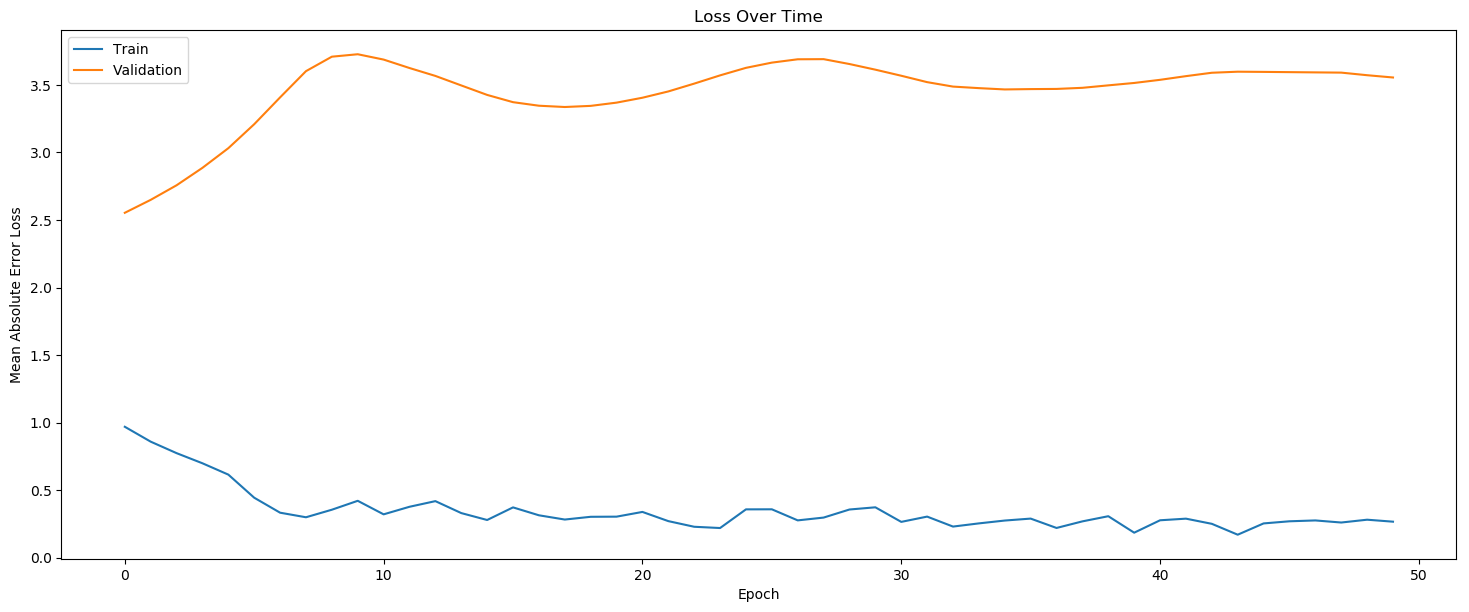

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Validation']);

# Predict

In [87]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [88]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [89]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [90]:
predict_and_plot(encoder_input_data, decoder_target_data, 20)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16534, enc_tail_len=100)

# Additional Resources

Many thanks to my amazing colleague [Joe Eddy](https://www.linkedin.com/in/joseph-eddy-178425129/) for his informative blog posts on WaveNet:
- [Time Series Forecasting with Convolutional Neural Networks - a Look at WaveNet](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/)
- [Time Series Forecasting with Convolutional Neural Networks - Further Exploration of WaveNet](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv2/)
- Optional context: [Forecasting with Neural Networks - An Introduction to Sequence-to-Sequence Modeling Of Time Series](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/)


## WaveNet Official
- [Blog on audio applications](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)
- [Voice showcase](https://cloud.google.com/text-to-speech/docs/wavenet)
- [Paper](https://arxiv.org/abs/1609.03499)
- [Wiki](https://en.wikipedia.org/wiki/WaveNet)